# Learning from multi-instance/multi-label data using DeliciousMIL dataset
### Panagiotis Doupidis, 89

In [1]:
import numpy as np
import os
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, zero_one_loss, coverage_error, label_ranking_loss, label_ranking_average_precision_score

import matplotlib.pyplot as plt

# Part 1

#### Read the vocabulary file in order to match the indexes with their corresponding words later

In [2]:
with open(os.path.join(os.path.curdir, 'Data', "vocabs.txt")) as f:
    vocab = {int(k.strip()): v for line in f for (v, k) in [line.strip().split(',', 1)]}

#### Read the train & test files with the documents and remove anything inside <>
#### Also, join all the sentences in each document to create a BOW scenario
#### Finally, convert numbers to text for readability

In [3]:
remove_sent_nums = re.compile(r'[\(\<].*?[\)\>]')

train_docs = []
test_docs = []

with open(os.path.join(os.path.curdir, 'Data', 'train-data.dat')) as infile:
    lines = infile.readlines()
    for line in lines:
        doc = ' '.join(re.sub(remove_sent_nums, '', line).split()).split()
        train_docs += [' '.join([vocab[int(k)] for k in doc])]

with open(os.path.join(os.path.curdir, 'Data', 'test-data.dat')) as infile:
    lines = infile.readlines()
    for line in lines:
        doc = ' '.join(re.sub(remove_sent_nums, '', line).split()).split()
        test_docs += [' '.join([vocab[int(k)] for k in doc])]

#### Count frequencies of words in each document

In [4]:
cv = CountVectorizer(lowercase=False, analyzer='word')

X_train = cv.fit_transform(train_docs).toarray()
X_test = cv.transform(test_docs).toarray()

#### Read the response variable with the classes that each document is assigned to

In [5]:
y_train = []
y_test = []

with open(os.path.join(os.path.curdir, 'Data', 'train-label.dat')) as infile:
    lines = infile.readlines()
    for line in lines:
        y_train += [list(map(int, line.split()))]

with open(os.path.join(os.path.curdir, 'Data', 'test-label.dat')) as infile:
    lines = infile.readlines()
    for line in lines:
        y_test += [list(map(int, line.split()))]

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

## Binary Relevance

In [6]:
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

classifiers = [('Logistic Reg', MultiOutputClassifier(LogisticRegression(solver='lbfgs', max_iter=100), n_jobs=4)),
                ('Decision Tree', MultiOutputClassifier(DecisionTreeClassifier(criterion='entropy'), n_jobs=4)),
                ('Naive Bayes', MultiOutputClassifier(MultinomialNB(), n_jobs=4))]

names = ('programming', 'style', 'reference', 'java', 'web', 'internet', 'culture', 'design', 'education', 'language', 'books',
    'writing', 'computer', 'english', 'politics', 'history', 'philosophy', 'science', 'religion', 'grammar')

zo_loss = []
ce = []
lr_loss = []
avg_prec = []

for name, clf in classifiers:
    print(name)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_proba = np.array([[k[1] for k in i] for i in clf.predict_proba(X_test)]).T

    print(classification_report(y_test, y_pred, target_names=names, digits=3, zero_division='warn'))
    print(f'Subset accuracy: {(1-zero_one_loss(y_test, y_pred)):.4}')
    print(f'coverage error: {coverage_error(y_test, y_proba): .4}')
    print(f'ranking loss: {label_ranking_loss(y_test, y_proba):.4}')
    print(f'average precision: {label_ranking_average_precision_score(y_test, y_proba):.4}')
    
    zo_loss += [1-zero_one_loss(y_test, y_pred)]
    ce += [coverage_error(y_test, y_proba)]
    lr_loss += [label_ranking_loss(y_test, y_proba)]
    avg_prec += [label_ranking_average_precision_score(y_test, y_proba)]
    
    print('=' * 70)

Logistic Reg
              precision    recall  f1-score   support

 programming      0.692     0.624     0.656       977
       style      0.524     0.377     0.439       228
   reference      0.524     0.494     0.508      1558
        java      0.689     0.543     0.608       372
         web      0.541     0.507     0.523      1050
    internet      0.349     0.328     0.338       537
     culture      0.385     0.308     0.342       702
      design      0.517     0.462     0.488      1079
   education      0.477     0.389     0.428       803
    language      0.504     0.393     0.442       483
       books      0.499     0.416     0.454       507
     writing      0.474     0.345     0.400       478
    computer      0.403     0.310     0.351       509
     english      0.451     0.346     0.392       355
    politics      0.564     0.429     0.487       392
     history      0.432     0.304     0.357       441
  philosophy      0.413     0.327     0.365       269
     science  

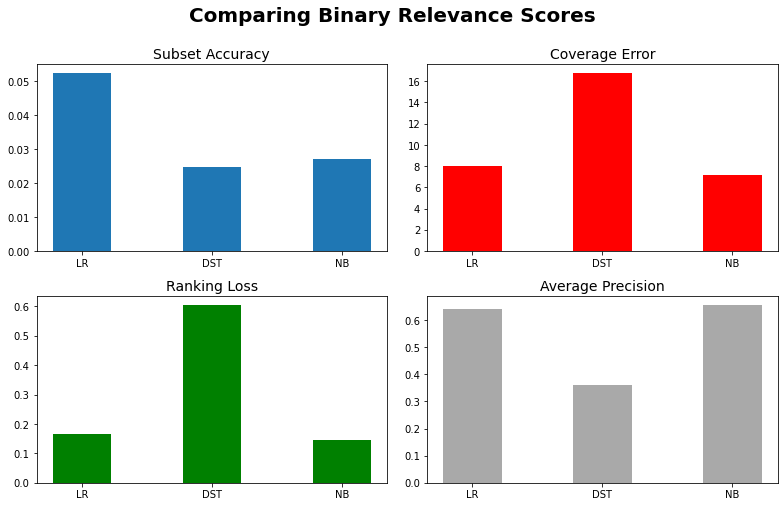

In [7]:
x = np.arange(len(classifiers))  # the label locations
width = 0.45  # the width of the bars

subset_acc = zo_loss
cov_error = ce
rank_loss = lr_loss
avg_prec = avg_prec

fig, axs = plt.subplots(2, 2)

axs[0, 0].bar(x, subset_acc, width, label='subset')
axs[0, 0].set_title('Subset Accuracy', fontsize=14)
axs[0, 1].bar(x, cov_error, width, label='subset', color='red')
axs[0, 1].set_title('Coverage Error', fontsize=14)
axs[1, 0].bar(x, rank_loss, width, label='subset', color='green')
axs[1, 0].set_title('Ranking Loss', fontsize=14)
axs[1, 1].bar(x, avg_prec, width, label='subset', color='darkgray')
axs[1, 1].set_title('Average Precision', fontsize=14)

for ax in axs.flat: 
    ax.set_xticks(x, ['LR', 'DST', 'NB'])

fig.suptitle('Comparing Binary Relevance Scores', fontsize=20, y=1, fontweight='bold')
fig.set_size_inches([11,7])
fig.tight_layout()

## Classifier Chain

In [8]:
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

classifiers = [('Logistic Reg', ClassifierChain(LogisticRegression(solver='lbfgs'), order='random')),
                ('Decision Tree', ClassifierChain(DecisionTreeClassifier(criterion='entropy', max_features=1000), order='random')),
                ('Naive Bayes', ClassifierChain(MultinomialNB(), order='random'))]

names = ('programming', 'style', 'reference', 'java', 'web', 'internet', 'culture', 'design', 'education', 'language', 'books',
    'writing', 'computer', 'english', 'politics', 'history', 'philosophy', 'science', 'religion', 'grammar')

zo_loss = []
ce = []
lr_loss = []
avg_prec = []

for name, clf in classifiers:
    print(name)
    clf.fit(X_train, y_train)

    print(f'Classifier {name} fitting done.')
    
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)

    print(classification_report(y_test, y_pred, target_names=names, digits=3, zero_division='warn'))
    print(f'Subset accuracy: {(1-zero_one_loss(y_test, y_pred)):.4}')
    print(f'coverage error: {coverage_error(y_test, y_proba): .4}')
    print(f'ranking loss: {label_ranking_loss(y_test, y_proba):.4}')
    print(f'average precision: {label_ranking_average_precision_score(y_test, y_proba):.4}')
    
    zo_loss += [1-zero_one_loss(y_test, y_pred)]
    ce += [coverage_error(y_test, y_proba)]
    lr_loss += [label_ranking_loss(y_test, y_proba)]
    avg_prec += [label_ranking_average_precision_score(y_test, y_proba)]
    
    print('=' * 70)

Logistic Reg
Classifier Logistic Reg fitting done.
              precision    recall  f1-score   support

 programming      0.692     0.624     0.656       977
       style      0.569     0.382     0.457       228
   reference      0.534     0.470     0.500      1558
        java      0.663     0.546     0.599       372
         web      0.523     0.497     0.510      1050
    internet      0.330     0.345     0.337       537
     culture      0.414     0.312     0.356       702
      design      0.515     0.470     0.491      1079
   education      0.471     0.384     0.423       803
    language      0.495     0.383     0.432       483
       books      0.499     0.426     0.460       507
     writing      0.470     0.341     0.395       478
    computer      0.395     0.303     0.343       509
     english      0.430     0.335     0.377       355
    politics      0.540     0.416     0.470       392
     history      0.465     0.331     0.387       441
  philosophy      0.426     0.

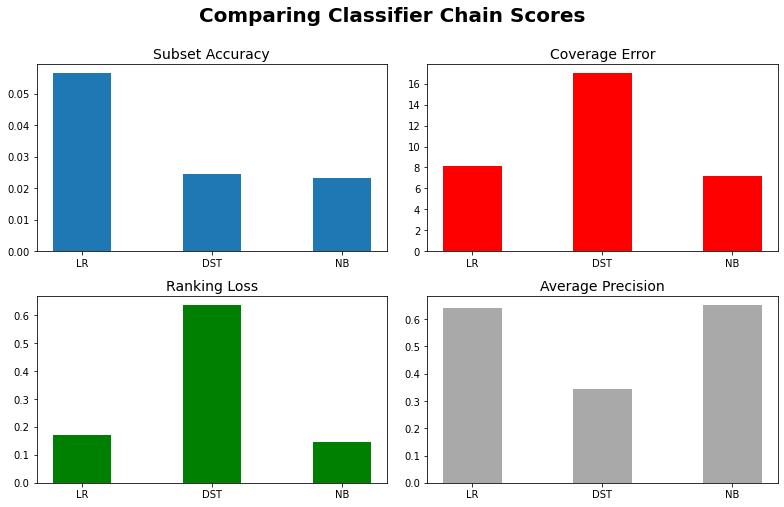

In [9]:
x = np.arange(len(classifiers))  # the label locations
width = 0.45  # the width of the bars

subset_acc = zo_loss
cov_error = ce
rank_loss = lr_loss
avg_prec = avg_prec

fig, axs = plt.subplots(2, 2)

axs[0, 0].bar(x, subset_acc, width, label='subset')
axs[0, 0].set_title('Subset Accuracy', fontsize=14)
axs[0, 1].bar(x, cov_error, width, label='subset', color='red')
axs[0, 1].set_title('Coverage Error', fontsize=14)
axs[1, 0].bar(x, rank_loss, width, label='subset', color='green')
axs[1, 0].set_title('Ranking Loss', fontsize=14)
axs[1, 1].bar(x, avg_prec, width, label='subset', color='darkgray')
axs[1, 1].set_title('Average Precision', fontsize=14)

for ax in axs.flat: 
    ax.set_xticks(x, ['LR', 'DST', 'NB'])

fig.suptitle('Comparing Classifier Chain Scores', fontsize=20, y=1, fontweight='bold')
fig.set_size_inches([11,7])
fig.tight_layout()

### The chosen metrics to evaluate the performance of the 2 methods are the ranking loss, coverage error, ranking loss and the average precision. Also, we have chosen to use 3 different machine learning algorithms to compare their performance wrapped in the 2 methods, Binary Relevance and Classifier Chain.

### The subset accuracy of both methods is very low (< 6%) which means that neither 2 methods could find all the correct labels in most of the examples of the test set. This could be due to the fact that by treating the documents as bags of words any correlation between sentences is lost, thus our models are missing some information that could potentially increase performance. In the case of average error and ranking loss we can spot a pattern, the Decision trees produce the worst results in both methods whereas Logistic Regreession and Naive Bayes are fairly equal. Looking at the average precision graphs we can claim that both methods achieve roughly the same levels of precision (~ 62%) using the LR and NB algorithms and Decision trees output nearly half that (~34%)

### To summarize, in our tests we cannot safely choose one method over the other in this particular dataset using the parameters specified above. In terms of speed Classifier Chains took considerably more time to run which was not a surprise considering the incremental nature of the method.

---

# Part 2

In [10]:
import numpy as np
import os
import re
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import normalize
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#### Read the 2 files containing the documents(train, test) and read their sentences

In [11]:
with open(os.path.join(os.path.curdir, 'Data', "vocabs.txt")) as f:
    vocab = {int(k.strip()): v for line in f for (v, k) in [line.strip().split(',', 1)]}

remove_sent_nums = re.compile(r'[\(\<].*?[\)\>]')

train_docs = []
test_docs = []

with open(os.path.join(os.path.curdir, 'Data', 'train-data.dat')) as infile:
    lines = infile.readlines()
    for line in lines:
        doc = ' '.join(re.sub(remove_sent_nums, '', line).split()).split()
        train_docs += [' '.join([vocab[int(k)] for k in doc])]

with open(os.path.join(os.path.curdir, 'Data', 'test-data.dat')) as infile:
    lines = infile.readlines()
    for line in lines:
        doc = ' '.join(re.sub(remove_sent_nums, '', line).split()).split()
        test_docs += [' '.join([vocab[int(k)] for k in doc])]

In [12]:
y_train = []
y_test = []

with open(os.path.join(os.path.curdir, 'Data', 'train-label.dat')) as infile:
    lines = infile.readlines()
    for line in lines:
        y_train += [list(map(int, line.split()))]

with open(os.path.join(os.path.curdir, 'Data', 'test-label.dat')) as infile:
    lines = infile.readlines()
    for line in lines:
        y_test += [list(map(int, line.split()))]

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

### Find the class with the highest frequency among the training data

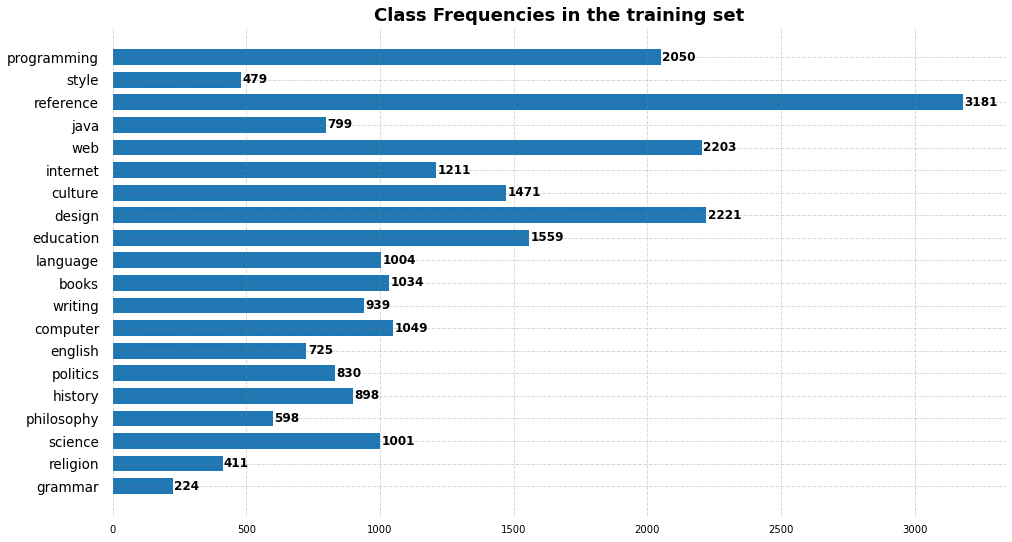

In [13]:
warnings.filterwarnings('ignore')

class_freqs = np.sum(y_train, axis=0)

names = ('programming', 'style', 'reference', 'java', 'web', 'internet', 'culture', 'design', 'education', 'language', 'books',
    'writing', 'computer', 'english', 'politics', 'history', 'philosophy', 'science', 'religion', 'grammar')

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(names, class_freqs, .7)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+5, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 12, fontweight ='bold',
             color ='black')
 
# Add Plot Title
ax.set_title('Class Frequencies in the training set', fontweight='bold', fontsize=18)
ax.set_yticklabels(names, fontsize=13.5)
# Show Plot
plt.show()

In [14]:
print (f'Class "{names[np.argmax(class_freqs)]}" is the most frequent among the training set')

Class "reference" is the most frequent among the training set


### We are going to focus our attention to the class "reference" to make the binary classification task

---

### Read the 2 files again (train, test) and parse them so that each sentence is a unique entry in the new dataset that will be created

In [15]:
# Get all the sentences

train_sents = []
count_sents_per_doc_train = []
test_sents = []
count_sents_per_doc_test = []

with open(os.path.join(os.path.curdir, 'Data', 'train-data.dat')) as infile:
    lines = infile.readlines()
    for line in lines:
        count_sents_per_doc_train += [int(line.split()[0].removeprefix('<').removesuffix('>'))]
        remove_sent_counter = re.sub(r"^\S*\s+", '', line)
        doc = ' '.join(re.sub(remove_sent_nums, '*', remove_sent_counter).split()).split('*')
        sents = [[i.strip().split()][0] for i in doc if i is not '']
        sents_to_int = [np.asarray(sent).astype(int).tolist() for sent in sents]
        train_sents += sents_to_int

print(f'Found {len(train_sents)} sentences in the training set')

with open(os.path.join(os.path.curdir, 'Data', 'test-data.dat')) as infile:
    lines = infile.readlines()
    for line in lines:
        count_sents_per_doc_test += [int(line.split()[0].removeprefix('<').removesuffix('>'))]
        remove_sent_counter = re.sub(r"^\S*\s+", '', line)
        doc = ' '.join(re.sub(remove_sent_nums, '*', remove_sent_counter).split()).split('*')
        sents = [[i.strip().split()][0] for i in doc if i is not '']
        sents_to_int = [np.asarray(sent).astype(int).tolist() for sent in sents]
        test_sents += sents_to_int

print(f'Found {len(test_sents)} sentences in the test set')

Found 149925 sentences in the training set
Found 73363 sentences in the test set


In [16]:
# print the first 10 sentences
train_sents[:10]

[[6705, 5997, 8310, 3606, 674, 8058, 5044, 4836],
 [4312, 5154, 8310, 4225],
 [1827, 1037, 8482, 483],
 [3567, 6172, 6172, 2892, 1362, 787, 399, 777, 1332],
 [318, 769, 4621, 3199, 1480, 6213, 971, 6890],
 [5909, 15, 3445, 2475],
 [324, 4138, 3404, 6176],
 [65, 2926, 1375, 7705],
 [709, 1323, 1652],
 [5735, 7439, 3445, 2475]]

### Convert each sentence to their corresponding word


In [17]:
train_sents_to_words = [' '.join([vocab[k] for k in sent]) for sent in train_sents]
test_sents_to_words = [' '.join([vocab[k] for k in sent]) for sent in test_sents]

In [18]:
# print the first 10 sentences
train_sents_to_words[:10]

['rubi rail helper demo more info auto complet',
 'see new helper action',
 'null length substr locat',
 'exec messag messag pleas edit remov follow word content',
 'roll stone com news song previou next page',
 'good vibrat beach boy',
 'smell teen spirit nirvana',
 'want hold hand beatl',
 'hound dog elvi',
 'god know beach boy']

#### Get the number occurencies of each word in every sentence (use binary occurence since our matrix is very sparse)

In [19]:
cv = CountVectorizer(lowercase=False, analyzer='word', binary=True)

X_train = cv.fit_transform(train_sents_to_words)
X_test = cv.transform(test_sents_to_words)

print(f'Shape of training data matrix : {X_train.shape[0]} x {X_train.shape[1]}')

Shape of training data matrix : 149925 x 8520


### Normalize the input matrix 

In [20]:
norm = Normalizer(norm='l2')

X_train = norm.fit_transform(X_train)
X_test = norm.transform(X_test)

### Reduce the dimensions using SVD (for K-means)

In [21]:
np.random.seed(52)

svd = TruncatedSVD(n_components=15, algorithm='arpack')
X_train = svd.fit_transform(X_train)
X_test = svd.transform(X_test)

In [22]:
# expand the classes

most_freq_idx = np.argmax(class_freqs)

y_train_expanded = np.repeat(y_train[:, most_freq_idx], count_sents_per_doc_train)
y_test_expanded = np.repeat(y_test[:, most_freq_idx], count_sents_per_doc_test)

In [23]:
print(f'Max features are {max(count_sents_per_doc_train)} based on the training dataset')

Max features are 31 based on the training dataset


### Find the optimal number of clusters using the silhouette score and the elbow method


In [24]:
# Find the best number of features using silhouette score
# Use MiniBatch Kmeans variant that is optimized for large-scale datasets using batches of data in each iteration
np.random.seed(52)

silhouette_avg = []
inertia = []

cluster_range = np.arange(5, 110, 10)

# Get random sample of 15% rows from the initial matrix for performance
X_train_sample = X_train[np.random.choice(X_train.shape[0], np.int(X_train.shape[0] * .15), replace=False), :]

for clusters in cluster_range:
    model = MiniBatchKMeans(n_clusters=clusters, batch_size=1024, n_init=10, init='k-means++').fit(X_train_sample) 
    score = silhouette_score(X_train_sample, model.labels_)
    silhouette_avg += [score]
    inertia += [model.inertia_]
    print(f'Silhouette score for {clusters:2} clusters: {score:2.4} (Inertia : {model.inertia_:.2})')
    

Silhouette score for  5 clusters: 0.5244 (Inertia : 1e+03)
Silhouette score for 15 clusters: 0.412 (Inertia : 4.2e+02)
Silhouette score for 25 clusters: 0.2813 (Inertia : 3.2e+02)
Silhouette score for 35 clusters: 0.1885 (Inertia : 3e+02)
Silhouette score for 45 clusters: 0.2068 (Inertia : 2.9e+02)
Silhouette score for 55 clusters: 0.2053 (Inertia : 2.7e+02)
Silhouette score for 65 clusters: 0.1759 (Inertia : 2.4e+02)
Silhouette score for 75 clusters: 0.1486 (Inertia : 2.5e+02)
Silhouette score for 85 clusters: 0.1643 (Inertia : 2.2e+02)
Silhouette score for 95 clusters: 0.1578 (Inertia : 2.3e+02)
Silhouette score for 105 clusters: 0.1694 (Inertia : 1.8e+02)


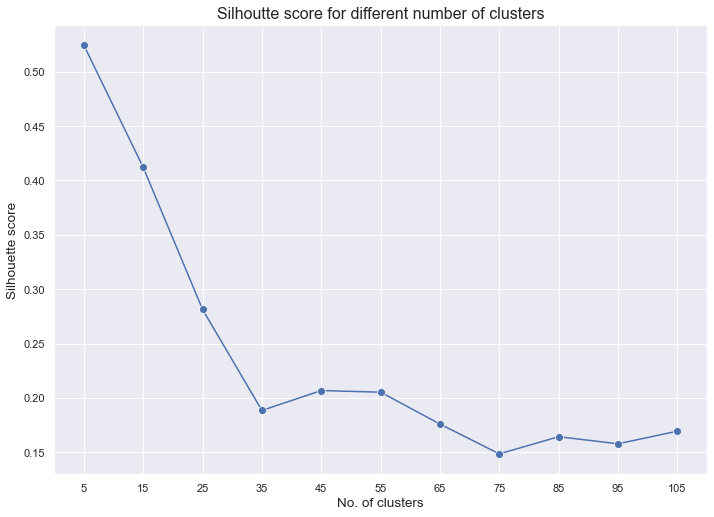

In [25]:
# Plot silhouette scores

sns.set(rc={'figure.figsize':(11.7,8.27)})
silh_plot = sns.lineplot(x=cluster_range, y=silhouette_avg, marker='o', markersize=8, ci=None)
silh_plot.set_xticks(cluster_range)
silh_plot.set_xlabel('No. of clusters', fontsize=13.5)
silh_plot.set_ylabel('Silhouette score', fontsize=13.5)
plt.title('Silhoutte score for different number of clusters', fontsize=16)
plt.show()

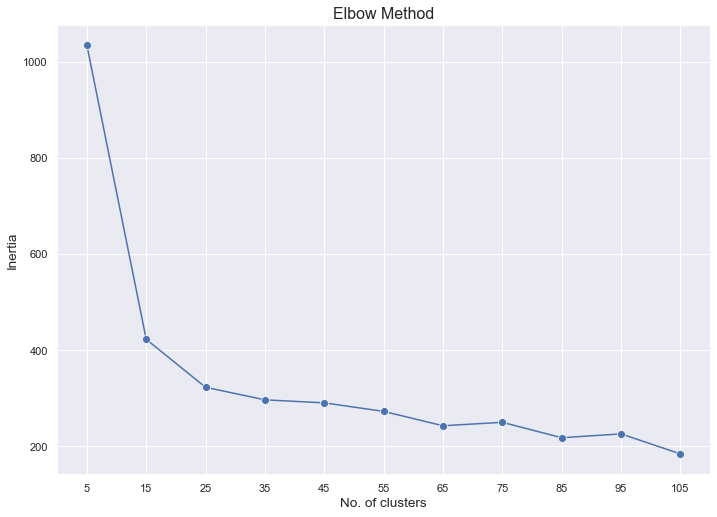

In [26]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
silh_plot = sns.lineplot(x=cluster_range, y=inertia, marker='o', markersize=8, ci=None)
silh_plot.set_xticks(cluster_range)
silh_plot.set_xlabel('No. of clusters', fontsize=13.5)
silh_plot.set_ylabel('Inertia', fontsize=13.5)
plt.title('Elbow Method', fontsize=16)
plt.show()

### Silhoutte score is rather inconclusive here since it suggests a very small number of clusters as the optimal but cluster inertia is very high. Using the elbow method we believe a reasonable numbers of clusters is around 35 since the slope decreases at a much more slow and steady way after 35-40 clusters

### Fit the k-means model to our training data to obtain the cluster that each sentence is assigned for every one document

In [27]:
# around 35 clusters according to the elbow diagram
np.random.seed(42)

no_clusters = 35

kmeans_final = KMeans(n_clusters=no_clusters, n_init=10, algorithm="full")
kmeans_final.fit(X_train)
                      
X_train_transf = list(zip(kmeans_final.labels_ ,np.repeat(np.arange(len(count_sents_per_doc_train)), count_sents_per_doc_train)))

In [28]:
X_train_transf = np.asarray(X_train_transf).reshape(-1, 2)

### We transform the initial X_train to another matrix with as many rows as our initial sentences and 2 columns. The first column represents the cluster this sentence is assinged to and the second column the document the sentence belongs to

In [29]:
X_train_transf[:5]

array([[ 9,  0],
       [ 1,  0],
       [ 0,  1],
       [21,  1],
       [11,  1]])

### Create a list of lists where each list is comprised of the clusters that the sentences of that document belong to. These lists have a length equal to the number of sentences in each document

In [30]:
indexes_to_turn = [X_train_transf[np.where(X_train_transf[:, 1] == i)][:, 0].tolist() for i in range(len(count_sents_per_doc_train))]

In [31]:
print(indexes_to_turn[:5])

[[9, 1], [0, 21, 11, 0, 0, 18, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [21, 21, 18, 0, 0, 0, 15, 0, 0, 26, 6, 18, 21, 6, 8, 9, 25, 21, 0, 18, 25, 21, 21, 25, 23, 21, 25, 21, 29, 25, 21], [1, 15], [27, 22, 22, 25, 21, 9, 15]]


### Create an empty array with dimensions (no. of documents x no. of clusters) and assign true (1) to the appropriate index according to the index list created above. This will iterate over all the rows in our indexes_to_turn variable and flip the numbers (0->1) at the appropriate indices in the empty matrix we created

In [32]:
new_features_arr = np.zeros((len(count_sents_per_doc_train), no_clusters), dtype=int)

for idxs, row in zip(indexes_to_turn, new_features_arr):
    row[idxs] = 1

### Repeat process for test set

In [33]:
X_test_transf = list(zip(kmeans_final.predict(X_test) ,np.repeat(np.arange(len(count_sents_per_doc_test)), count_sents_per_doc_test)))

In [34]:
X_test_transf = np.asarray(X_test_transf).reshape(-1, 2)

In [35]:
indexes_to_turn_test = [X_test_transf[np.where(X_test_transf[:, 1] == i)][:, 0].tolist() for i in range(len(count_sents_per_doc_test))]

In [36]:
new_features_arr_test = np.zeros((len(count_sents_per_doc_test), no_clusters), dtype=int)

for idxs, row in zip(indexes_to_turn_test, new_features_arr_test):
    row[idxs] = 1

### Get the value for the most frequent class in our training dataset

In [37]:
y_train_most_freq = y_train[:, np.argmax(class_freqs)]
y_test_most_freq = y_test[:, np.argmax(class_freqs)]

### Train traditional classifiers with our transformed input matrix after running k-means

In [38]:
clfs = [LogisticRegression(), DecisionTreeClassifier(), LinearSVC()]

### Do grid search to estimate the optimal parameters for our models

In [39]:
np.random.seed(52)

scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score),
          'f1': make_scorer(f1_score)}

gs_lr = GridSearchCV(clfs[0], param_grid={'penalty': ['l1', 'l2'], 
                                         'tol':[1, 1e-1, 1e-2, 1e-3], 'C':[100, 10, 1, 1e-1, 1e-2],
                                         'class_weight': ['balanced']}, verbose=1, scoring=scoring, cv=10, refit='Accuracy')

gs_lr.fit(new_features_arr, y_train_most_freq)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [100, 10, 1, 0.1, 0.01],
                         'class_weight': ['balanced'], 'penalty': ['l1', 'l2'],
                         'tol': [1, 0.1, 0.01, 0.001]},
             refit='Accuracy',
             scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)},
             verbose=1)

In [40]:
np.random.seed(52)

gs_dt = GridSearchCV(clfs[1], param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 5, 10, 20],
                                         'min_samples_split': [2, 3, 4, 5, 10],
                                         'max_features':[.1, .2, .4, .5, .7, 'log2', 'sqrt'],
                                         'max_leaf_nodes': [2, 3, 5, 7, 10, 15]}, 
                                             verbose=1, scoring=scoring, cv=10, refit='Accuracy', n_jobs=-1)

gs_dt.fit(new_features_arr, y_train_most_freq)

Fitting 10 folds for each of 1680 candidates, totalling 16800 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 10, 20],
                         'max_features': [0.1, 0.2, 0.4, 0.5, 0.7, 'log2',
                                          'sqrt'],
                         'max_leaf_nodes': [2, 3, 5, 7, 10, 15],
                         'min_samples_split': [2, 3, 4, 5, 10]},
             refit='Accuracy',
             scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)},
             verbose=1)

In [41]:
np.random.seed(52)

gs_svm = GridSearchCV(clfs[2], param_grid={'tol': [1e-3, 1e-2, 1, 1e2, 50], 'penalty': ['l1', 'l2'],
                                          'loss': ['hinge', 'squared_hinge']}, 
                                             verbose=1, scoring=scoring, cv=10, refit='Accuracy', n_jobs=-1)

gs_svm.fit(new_features_arr, y_train_most_freq)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=10, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l1', 'l2'],
                         'tol': [0.001, 0.01, 1, 100.0, 50]},
             refit='Accuracy',
             scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)},
             verbose=1)

### Fit the classifiers and estimate the scores

In [42]:
np.random.seed(52)

clfs = [LogisticRegression(**gs_lr.best_params_), DecisionTreeClassifier(**gs_dt.best_params_), 
        LinearSVC(**gs_svm.best_params_)]

acc_mil = []
rec_mil = []
prec_mil = []
f1_mil = []

for clf in clfs:
    print(clf.__class__.__name__, end='\n\n')
    
    clf.fit(new_features_arr, y_train_most_freq)
    y_pred = clf.predict(new_features_arr_test)
    
    print(classification_report(y_test_most_freq, y_pred, digits=3, zero_division='warn'))
    print(f'Accuracy: {accuracy_score(y_test_most_freq, y_pred):.4}')
    print(f'Recall: {recall_score(y_test_most_freq, y_pred):.4}')
    print(f'Precision: {precision_score(y_test_most_freq, y_pred):.4}')
    print(f'F1 score: {f1_score(y_test_most_freq, y_pred):.4}')
    
    acc_mil += [accuracy_score(y_test_most_freq, y_pred)]
    rec_mil += [recall_score(y_test_most_freq, y_pred)]
    prec_mil += [precision_score(y_test_most_freq, y_pred)]
    f1_mil += [f1_score(y_test_most_freq, y_pred)]
    
    print('=' * 60, end='\n\n')
        

LogisticRegression

              precision    recall  f1-score   support

           0      0.681     0.599     0.637      2425
           1      0.474     0.562     0.514      1558

    accuracy                          0.585      3983
   macro avg      0.577     0.581     0.576      3983
weighted avg      0.600     0.585     0.589      3983

Accuracy: 0.5847
Recall: 0.5623
Precision: 0.474
F1 score: 0.5144

DecisionTreeClassifier

              precision    recall  f1-score   support

           0      0.618     0.944     0.747      2425
           1      0.513     0.092     0.156      1558

    accuracy                          0.611      3983
   macro avg      0.565     0.518     0.451      3983
weighted avg      0.577     0.611     0.516      3983

Accuracy: 0.6106
Recall: 0.09178
Precision: 0.5125
F1 score: 0.1557

LinearSVC

              precision    recall  f1-score   support

           0      0.633     0.910     0.746      2425
           1      0.560     0.178     0.270   

## Compare with a non multi instance approach

In [43]:
remove_sent_nums = re.compile(r'[\(\<].*?[\)\>]')

train_docs = []
test_docs = []

with open(os.path.join(os.path.curdir, 'Data', 'train-data.dat')) as infile:
    lines = infile.readlines()
    for line in lines:
        doc = ' '.join(re.sub(remove_sent_nums, '', line).split()).split()
        train_docs += [' '.join([vocab[int(k)] for k in doc])]

with open(os.path.join(os.path.curdir, 'Data', 'test-data.dat')) as infile:
    lines = infile.readlines()
    for line in lines:
        doc = ' '.join(re.sub(remove_sent_nums, '', line).split()).split()
        test_docs += [' '.join([vocab[int(k)] for k in doc])]

y_train_non = []
y_test_non = []

with open(os.path.join(os.path.curdir, 'Data', 'train-label.dat')) as infile:
    lines = infile.readlines()
    for line in lines:
        y_train_non += [list(map(int, line.split()))]

with open(os.path.join(os.path.curdir, 'Data', 'test-label.dat')) as infile:
    lines = infile.readlines()
    for line in lines:
        y_test_non += [list(map(int, line.split()))]

y_train_non = np.asarray(y_train_non)[:, np.argmax(class_freqs)]
y_test_non = np.asarray(y_test_non)[:, np.argmax(class_freqs)]

In [44]:
cv = CountVectorizer(lowercase=False, analyzer='word', binary=True)

X_train_non = cv.fit_transform(train_docs).toarray()
X_test_non = cv.transform(test_docs).toarray()

### Train the models using a BOW approach 

In [45]:
np.random.seed(52)

clfs = [LogisticRegression(solver='lbfgs'), DecisionTreeClassifier(criterion='entropy'), LinearSVC()]

acc_nonmil = []
rec_nonmil = []
prec_nonmil = []
f1_nonmil = []

for clf in clfs:
    print(clf.__class__.__name__, end='\n\n')
    
    clf.fit(X_train_non, y_train_non)
    y_pred = clf.predict(X_test_non)
    
    print(classification_report(y_test_non, y_pred, digits=3, zero_division='warn'))
    print(f'Accuracy: {accuracy_score(y_test_non, y_pred):.4}')
    print(f'Recall: {recall_score(y_test_non, y_pred):.4}')
    print(f'Precision: {precision_score(y_test_non, y_pred):.4}')
    print(f'F1 score: {f1_score(y_test_non, y_pred):.4}')
    
    acc_nonmil += [accuracy_score(y_test_non, y_pred)]
    rec_nonmil += [recall_score(y_test_non, y_pred)]
    prec_nonmil += [precision_score(y_test_non, y_pred)]
    f1_nonmil += [f1_score(y_test_non, y_pred)]
    
    print('=' * 60, end='\n\n')

LogisticRegression

              precision    recall  f1-score   support

           0      0.693     0.729     0.711      2425
           1      0.542     0.497     0.519      1558

    accuracy                          0.639      3983
   macro avg      0.617     0.613     0.615      3983
weighted avg      0.634     0.639     0.636      3983

Accuracy: 0.6387
Recall: 0.4974
Precision: 0.5416
F1 score: 0.5186

DecisionTreeClassifier

              precision    recall  f1-score   support

           0      0.656     0.667     0.661      2425
           1      0.467     0.454     0.461      1558

    accuracy                          0.584      3983
   macro avg      0.561     0.561     0.561      3983
weighted avg      0.582     0.584     0.583      3983

Accuracy: 0.584
Recall: 0.4544
Precision: 0.4673
F1 score: 0.4608

LinearSVC

              precision    recall  f1-score   support

           0      0.685     0.677     0.681      2425
           1      0.506     0.515     0.511    

In [46]:
# Plot the 2 approaches

def plot_metrics(mil_data, nonmil_data, classifier_name='Logistic Regression'):
    labels = ['Accuracy', 'Recall', 'Precision', 'F1']

    x = np.arange(len(labels))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots()
    
    rects1 = ax.bar(x - width/2, mil_data, width, label='Multi-Instance w/ K-Means clustering')
    rects2 = ax.bar(x + width/2, nonmil_data, width, label='Non Multi-Instance')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title(f'Comparing the 2 approaches using {classifier_name}', fontsize=16)
    ax.set_xticks(x, labels, fontsize=14)
    ax.set_yticks(np.arange(0, np.max(np.array([mil_data, nonmil_data]).flatten())+.1, .05))
    
    ax.legend()
    
    fig.tight_layout()
    
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    
    plt.show()

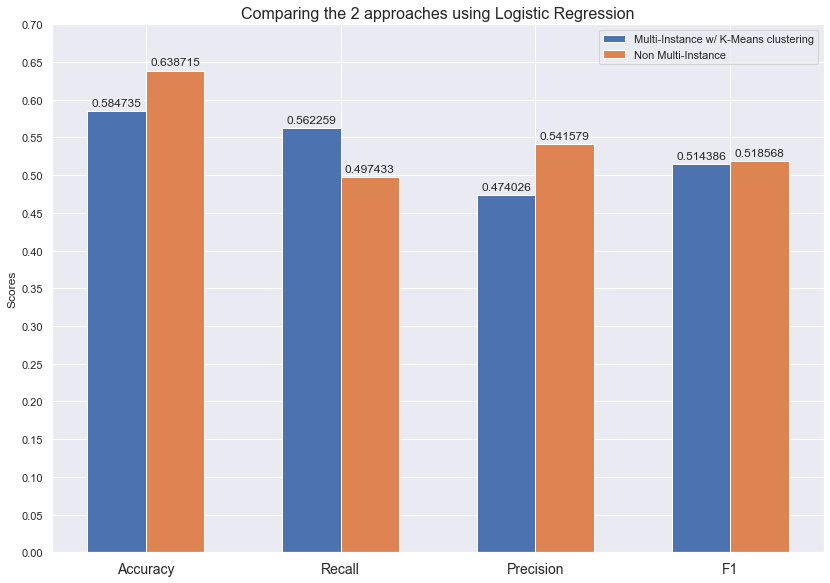

In [47]:
plot_metrics(list(map(lambda x : x[0], [acc_mil, rec_mil, prec_mil, f1_mil])), list(map(lambda x : x[0], [acc_nonmil, rec_nonmil, prec_nonmil, f1_nonmil])))

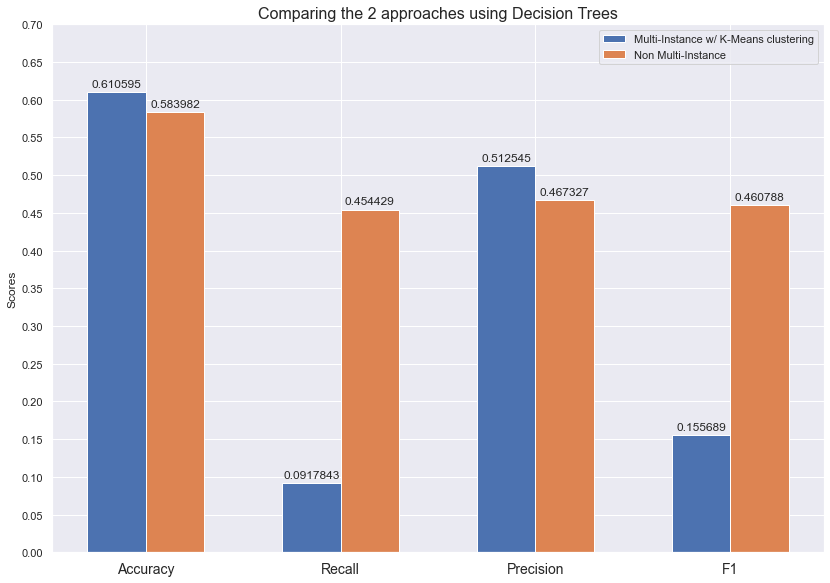

In [48]:
plot_metrics(list(map(lambda x : x[1], [acc_mil, rec_mil, prec_mil, f1_mil])), list(map(lambda x : x[1], [acc_nonmil, rec_nonmil, prec_nonmil, f1_nonmil])), classifier_name='Decision Trees')

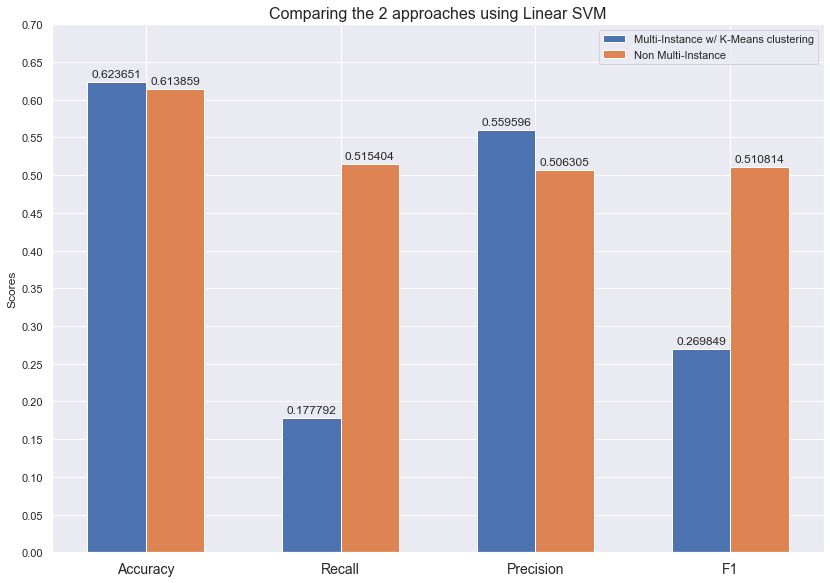

In [49]:
plot_metrics(list(map(lambda x : x[2], [acc_mil, rec_mil, prec_mil, f1_mil])), list(map(lambda x : x[2], [acc_nonmil, rec_nonmil, prec_nonmil, f1_nonmil])), classifier_name='Linear SVM')

### Starting with Logistic Regression we can see that our MIL model achieved a slightly better recall score but overall accuracy was about 5% less that the BOW counterpart.In general we can claim that the 2 models are very close in terms of performance.

### In our second model using Decision Trees we can see that accuracy and precision in our transformed MIL model is slightly higher although recall is very low (11%) which might indicate a large number of false negatives

### Finally using Linear SVM's we can see that they are also very similar to Decision Trees in terms of outperforming the BOW approach in accuracy and precision, although recall is still low (17%)

### As a note we can say that is it certainly not a trivial task to transform a MIL model to a single instance using K-means since there are a lot of different variables to take into account. We must admit that the end result has proven to be on par or perhaps a bit worse that the straight-forward BOW approach. Several other attempts without using dimensionality reduction or by increasing the number of clusters didn't improve the situation (actually making it worse) which we believe is noteworthy to add. An interesting extension would be to implement the K-medoids algorithm here to cluster the bags instead of the instances using the hausdoff distance metric - this could potentially yield better results.